In [ ]:
# PATHES
PATH = 'churn_modeling.csv'

In [ ]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

## Reading and understanding data:

In [ ]:
df = pd.read_csv(PATH)

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Dropping unnessesary columns:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
# Doing some statistics about region customers are from:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [ ]:
# Kowing each count for genders:
df['Gender'].value_counts()

,count
Gender,
Male,5457
Female,4543


In [ ]:
pd.pivot_table(df, values='IsActiveMember', index=['Gender', 'Geography'], aggfunc=np.sum)

<ipython-input-139-9cbac2810e44>:1: FutureWarning: The provided callable <function sum at 0x7879c937be20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(df, values='IsActiveMember', index=['Gender', 'Geography'], aggfunc=np.sum)


IsActiveMember
Gender Geography                
Female France               1162
       Germany               559
       Spain                 563
Male   France               1429
       Germany               689
       Spain                 749

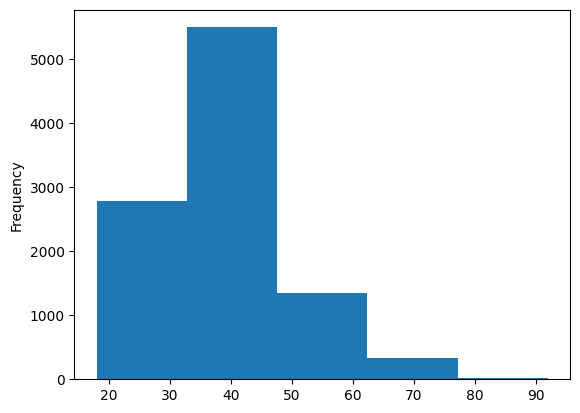

In [ ]:
# Knowing more about Age distribution
df['Age'].plot(kind='hist', bins=5);

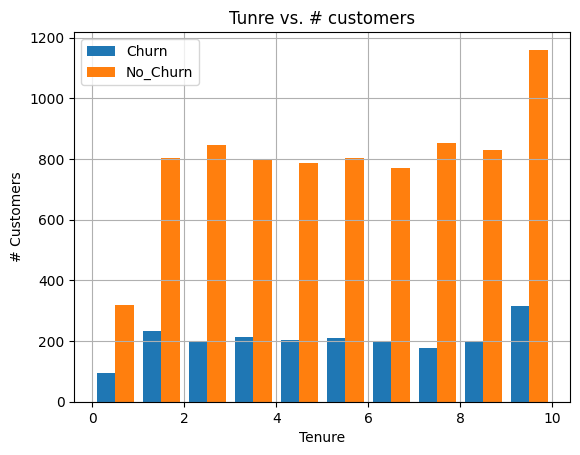

In [ ]:
# Histogram of tenure and churn intervals
churn_no = df[df['Exited']==0].Tenure
churn_yes = df[df['Exited']==1].Tenure

plt.hist([churn_yes, churn_no], label=['Churn', 'No_Churn'])
plt.legend()
plt.grid()
plt.xlabel('Tenure')
plt.ylabel('# Customers')
plt.title('Tunre vs. # customers')
plt.show()

### Data Preprocessing:

In [ ]:
# Encoding categorical values into numeric using onehot_encoding
ohe = OneHotEncoder()
df2 = pd.DataFrame(ohe.fit_transform(df[['Gender']]).toarray(), columns=ohe.categories_)
df2.head()

,Female,Male
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [ ]:
df3 = pd.DataFrame(ohe.fit_transform(df[['Geography']]).toarray(), columns=ohe.categories_)
df3.head()

,France,Germany,Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [ ]:
df.drop(['Geography', 'Gender'], axis='columns', inplace=True)
df = pd.concat([df, df2], axis=1)
df = pd.concat([df, df3], axis=1)

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,"(Female,)","(Male,)","(France,)","(Germany,)","(Spain,)"
0,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,1.0,0.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,1.0,0.0,0.0,0.0,1.0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,1.0,0.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,1.0,0.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,1.0,0.0,0.0,0.0,1.0


# Splitting the data:

In [ ]:
x = df.drop('Exited', axis='columns')
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(X_train.shape)

(8000, 13)


In [ ]:
cols_to_scale = ['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = MinMaxScaler()

scaler.fit(X_train[cols_to_scale])
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Building our Neural Network:

In [ ]:
#Import layers here
# 21 1 target 20 features

y_train.shape

(8000,)

In [ ]:
# Creating model
model = Sequential([
    Dense(units=150, input_shape=(13,), activation='relu', name='Input'),
    Dense(units=80, activation='relu', name='hidden_1'),
    Dense(units=30, activation='relu', name='hidden_2'),
    Dense(units=10, activation='relu', name='hidden_3'),
    Dense(units=2, activation='softmax', name='Output')
    # Dense(units=1, activation='sigmoid', name='Output')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (Dense)                        │ (None, 150)                 │           2,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_1 (Dense)                     │ (None, 80)                  │          12,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_2 (Dense)                     │ (None, 30)                  │           2,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_3 (Dense)                     │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,942 (66.18 KB)

 Trainable params: 16,942 (66.18 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile Model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.01),
             loss = 'sparse_categorical_crossentropy',
              # loss = 'categorical_crossentropy', ??? what do you think
              metrics = ['accuracy'])

In [ ]:
# create checkpoint to save model at the end of each epoch:
checkpoint = keras.callbacks.ModelCheckpoint("churn_model.keras", save_best_only=True)

# create EarlyStopping checkpoint:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


In [ ]:
# Fit model, put parameters as you wish
history = model.fit(X_train, y_train,
                   batch_size=64, epochs=30,
                   validation_split=5/60,
                   callbacks=[checkpoint, early_stopping])

Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7582 - loss: 0.6793 - val_accuracy: 0.8141 - val_loss: 0.4588
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - loss: 0.4604 - val_accuracy: 0.7991 - val_loss: 0.4439
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8043 - loss: 0.4450 - val_accuracy: 0.7961 - val_loss: 0.4705
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8047 - loss: 0.4425 - val_accuracy: 0.7946 - val_loss: 0.4277
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8048 - loss: 0.4394 - val_accuracy: 0.8246 - val_loss: 0.4156
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8067 - loss: 0.4431 - val_accuracy: 0.8006 - val_loss: 0.4360
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8152 - loss: 0.4216 - val_accuracy: 0.8261 - val_loss: 0.4128
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8184 - loss: 0.4206 - val_accuracy: 0.

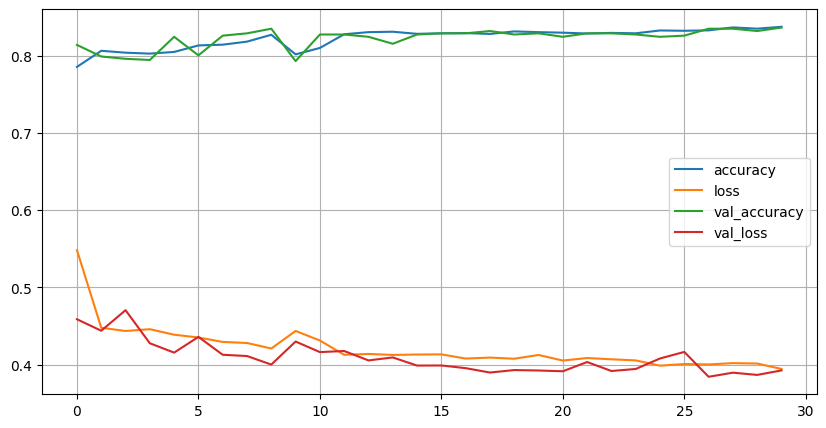

In [ ]:
learning_data = pd.DataFrame(history.history)
learning_data.plot(figsize=(10,5))
plt.grid(True)
plt.show()

In [ ]:
# Evaluate model

In [ ]:
X_pred = X_test[0,:].reshape(1,-1)
y_pred = model.predict(X_pred)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.85337853 0.14662144]]


In [ ]:
y_pred = np.argmax(model.predict(X_pred), axis=-1)
print('actual values', y_test[0])
print('predicted values', y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
actual values 0
predicted values [0]
